In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

/Users/Santiago/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
hotel = pd.read_csv('course_data/hotel.csv')
hotel.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [5]:
X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

In [6]:
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"),
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [7]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [8]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - binary_accuracy: 0.7400 - loss: 0.5367 - val_binary_accuracy: 0.8047 - val_loss: 0.4336
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8004 - loss: 0.4289 - val_binary_accuracy: 0.8134 - val_loss: 0.4037
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8092 - loss: 0.4089 - val_binary_accuracy: 0.8163 - val_loss: 0.3963
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8124 - loss: 0.4009 - val_binary_accuracy: 0.8205 - val_loss: 0.3910
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8131 - loss: 0.3969 - val_binary_accuracy: 0.8217 - val_loss: 0.3898
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8156 - loss: 0.3941 - val_binary_accuracy: 0.8246 - val_loss: 0.3838
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8207 - loss: 0.3856 - val_binary_accuracy: 0.8242 - val_loss: 0.3804

<Axes: title={'center': 'Accuracy'}>

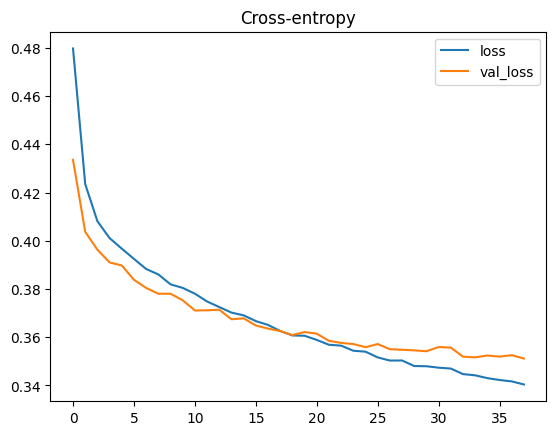

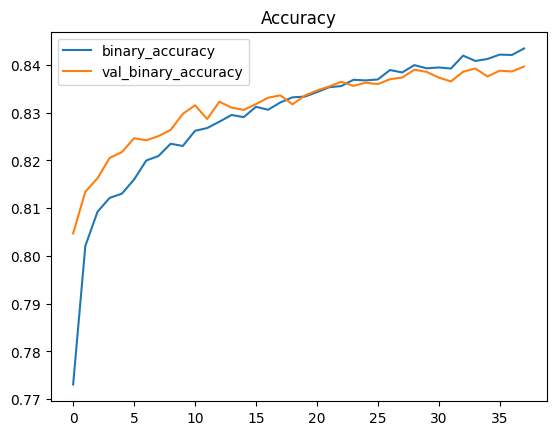

In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

Though we can see the training loss continuing to fall, the early stopping callback prevented any overfitting. Moreover, the accuracy rose at the same rate as the cross-entropy fell, so it appears that minimizing cross-entropy was a good stand-in. All in all, it looks like this training was a success!

